<img src="img/logo_wiwi_en_.png" width="30%" align="left">

<img src="img/decision_analytics_logo.png" width="17%" align="right">



<br><br><br><br><br><br><br><br>



# Combining OR and Data Science

**Summer Term 2023**


# 4. Decision Making Under Uncertainty, the Value of Information and Risk Aversion



<br>

<br>
<br>

**J-Prof. Dr. Michael Römer, Till Porrmann, Mohsen Nafar**

**Decision Analytics Group  | Bielefeld University**
                                                    
                                                


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numba import vectorize


## An Overview

In this meeting, we will review
- the **fundamental structure of decision-making problems under uncertainty**
- how to take decisions maximizing expected outcome
- how to use **unconstrained optimization** for selecting decisions

In addition, we will discuss
- the **value of proper decision-making under uncertainty**
- the **value of information** and its relation to decision-making under uncertainty

Furthermore, we will go beyond valuating decisions under uncertainty by expected values:
- we introduce the idea that **decision-making means shaping distributions** 
- and discuss different ways to **incorporate risk aversion in decision-making under uncertainty** 

### The Capacity Planning Case Study

- In this meeting, we once again use the capacity planning case study to illustrate aspects of decision making under uncertainty (see previous notebooks for details)

- it deals with the decision of installing a certain production capacity under **demand uncertainty**
- for a given capacity and for a given demand, we can compute  the profit using the following function:


In [2]:
#@vectorize turns a function into a just-in-time compiled vectorized function
@vectorize
def total_profit(capacity,demand):
    return -30*capacity + 40* min(capacity, demand)

- recall that by using `@vectorize` the function also be called with a demand array
- it then returns an array with profit values (one for each demand value)
- we can then approximate the expected profit by taking the average over that array

## Decision Making Under Uncertainty: Single-Stage Setting

- decisions have to be taken **here and now**, that is, **before** the uncertain information becomes known.

- in a single-stage setting, the decision maker **cannot react** to the uncertainty

<img width='1000' src='img/single_stage.png'>

In our case study, this looks as follows:


<img width='1000' src='img/single_stage_example.png'>

## Decision Making Under Uncertainty: Two-Stage Setting

- first-stage decisions have to be taken  **here and now**, that is, **before** the uncertain information becomes known.
- second-stage (**recourse**)  decisions that can  be taken after the information is available


<img width='1000' src='img/two_stage.png'>

We can interpret our case study as a two-stage problem:


<img width='1000' src='img/two_stage_example.png'>

## Evaluating a Given Decision with Decision Trees

Let us assume a given decision (here 100). 
- we can visualize our simulation-based approach as a decision tree 
- in the figure, we assume only tree sample values

<img width='1000' src='img/decision_tree_example.png'>



We can use our well-known computation to compute the value of the tree:

In [5]:
capacity = 100
demands = np.array([80,100,120])
profits = np.empty(3)

for i, demand in enumerate(demands):
    profits[i] = total_profit(capacity, demand)     
np.mean(profits)

733.3333333333334

Or, even shorter, in vectorized form:

In [6]:

profits = total_profit(capacity, demands) 
    
np.mean(profits)

733.3333333333334

## Choosing a Decision Under Uncertainty with Decision Trees

<img style='float: right' width='600' src='img/decision_tree_example_decisions.png'> 

For modeling the decision-making problem:
- add a branch for each decision after the decision node
- compute the expected performance of each branch
- select the branch with the best expected performance
- which one is it here?
- **note**: this is the principle of the enumeration approach with Monte Carlo approximation we performed before!



In [5]:
capacities = np.array([80,100,120])
average_profits = np.empty(3)
#observe: enumerate returns both the current index and the element of the array
for i, capacity in enumerate(capacities):
    average_profits[i] = np.mean(total_profit(capacity, demands))     
best_index = np.argmax(average_profits)
capacities[best_index]

80

## Taking the Best Decisions: Formalization

We are looking for
- the decision (or decision vector, or more general, solution) $x$ 
- from the set of possible decisions (solutions) $X$ 
-  yielding the *best* expected outcome $E(f(x,D))$
-  given the uncertain/random variable(s) $D$

We can write this as an *optimization* problem under uncertainty:

$$\max_{x \in X} E(f(x,D))$$

Using Monte Carlo, we approximate $E(f(x,D))$ by the mean of the
 output sample vector $\mathbf{f}(x,\mathbf{d})$, that is by
 $\frac{1}{|S|} \sum\limits_{s\in S} f(x,d_s)$ 

This results in the following optimization problem:

$$\max_{x\in X} \frac{1}{|S|} \sum\limits_{s\in S} f(x,d_s)$$


## Solving by Enumeration

**If** 
- the set $X$ is finite and not too big (there are just few number of decisions / plans to choose from)
- and $\frac{1}{|S|} \sum\limits_{s\in S} f(x,d_s)$ can be computed efficiently

**we can simply** 
-  **enumerate** all solutions / decisions  $x \in X$ 
- and **select** one maximizing $\frac{1}{|S|} \sum\limits_{s\in S} f(x,d_s)$

## Solving by Enumeration: In our Example


In our example, we may simply enumerate all (meaningful) capacity decisions $x$, e.g. from 0 to 200.
- and we use `np.argmax` to obtain the index of the best decision

In [63]:
capacities = np.arange(200)

demand_dist = stats.norm(100,25)

n_samples = 100000

demands = demand_dist.rvs(n_samples)

average_profits = np.empty(len(capacities))

for i, capacity in enumerate(capacities):
    # recall: given the vectorization, calling total_profits performs a Monte-Carlo Simulation!
    average_profits[i] = np.mean(total_profit(capacity, demands))

best_profit = np.max(average_profits)
best_index = np.argmax(average_profits)
best_capacity_decision = capacities[best_index]


print (f"The best decision is {best_capacity_decision} yielding an average profit of {best_profit:.02f}")


The best decision is 83 yielding an average profit of 684.67


## On Choosing and Using Samples

**Sample Size**
- as we know, too small sample sizes may lead to approximation error
- this error can lead to choosing a suboptimal solution

**Exercise**

To see this effect, try the following experiment: Use a small number of samples (say, 100) and carry out the optimization by enumeration.


**Observe: We are e-using samples (Common Random Numbers)**

It is helpful to use the same sample vector(s) for evaluating each solution:
- this leads to the same "experimental" conditions for each solution, and
- removes the chance-induced differences between the evaluations of each solutions
- is referred to as **common random numbers** and
- can be viewed as a **variance reduction** technique

 

## Using (Unconstrained) Optimization


Instead of enumerating all decisions (solutions) and picking the best one,
we may automate the search for the best decision(s) based on our Monte
Carlo approximation 


$$\max_{x\in X} \frac{1}{|S|} \sum\limits_{s\in S} f(x,d_s)$$

by **optimization methods**.

As an example, we may just use an unconstrained optimization routine:
- packages available in most languages, even in spreadsheets
- e.g. in **SciPy**, there is the package `optimize`
  - one can choose different algorithms
  - no optimality guarantee
  - only minimization (we can maximize by multiplying the objective with 1)
  - we give an arbitrary function as objective function


## Using Scipy's Optimize for Unconstrained Optimization

In order to use scipy optimize for our purposes, we need to address the following aspects:

- we need a function to optimize (we need to wrap the call of `mean`):

In [66]:
def expected_profit(capacity,demands):
    return np.mean(total_profit(capacity,demands))

- There is no maximize, but only a `minimize` function
  - to use it for maximization, we can just minimize a **function returning the negative objective function value**

In [67]:
from scipy.optimize import minimize

def neg_expected_profit(capacity, demands):
    return -1*np.mean(total_profit(capacity,demands))

When calling the `minimize` function, we need to provide:
- the function to optimize in which the first parameter is the (vector of) decision variable(s) (in our case, the capacity )
- an initial value for the decision variable(s)
- a tuple of the additional arguments of the function to optimize (in our case: the demand samples)

In [68]:
optimization_result = minimize(neg_expected_profit, 100, args=(demands))

print(f'The best decision is: {optimization_result.x[0]:.2f}, yielding an expected total profit of {-1* optimization_result.fun:.2f}')

The best decision is: 83.25, yielding an expected total profit of 684.69


..we may round this result, but recall that we compute in terms of 1000 units here!

# Exercise

## An additional production technology

The company from the capacity planning case study thinks of installing production capacity using an different production technology (B).

Technology B has a lower installation costs (\\$ 20 per unit), but also a lower contribution margin per sold unit (\\$ 28) compared to the original technology A.



**Excercise:**

Implement a Monte-Carlo-Approximation for the decision of how much capacity to install if you would use only technology B (assuming the same demand distribution as above)

What is the best possible expected profit?



In [69]:
@vectorize
def total_profit_b(capacity,demand):
    return -20*capacity + 28* min(capacity, demand)

def neg_expected_profit_b(capacity, demands):
    return -1*np.mean(total_profit_b(capacity,demands))

result_b = minimize(neg_expected_profit_b, 100, args=(demands))

print(f'The best decision is: {result_b.x[0]:.2f}, yielding an expected total profit of {-1* result_b.fun:.2f}')

The best decision is: 85.93, yielding an expected total profit of 563.89


**Excercise:**

Now consider a combination of both technologies, that is, you may install both technology A and B. 

Since B has a lower profit contribution, you assume that if  both technologies are installed, first A is used to produce up to the installed capacity. If there is demand left, that demand is satisfied by technology B until the installed capacity of B is exhausted.

What is the best combination of technologies A and B in terms of expected total profit? Is B used at all? 


In [95]:
@vectorize
def total_profit_combined(capacity_A, capacity_B, demand): 
    production_A = min(capacity_A, demand)
    demand_left = demand-production_A
    production_B = min(capacity_B, demand_left)
    profit_from_A = -30 * capacity_A+ 40*production_A
    profit_from_B = -20 * capacity_B+ 28*production_B
    return profit_from_A + profit_from_B

In [96]:
def neg_expected_profit_combined(capacities, demands):
    return -1*np.mean(total_profit_combined(capacities[0], capacities[1], demands))

result_combined = minimize(neg_expected_profit_combined, [100,0],  args=(demands))

print(f'The best decision is: {result_combined.x:}, yielding an expected total profit of {-1* result_combined.fun:.2f}')

The best decision is: [76.0315481   9.89856603], yielding an expected total profit of 689.55


# The Value of Including Uncertainty 

## The Flaw Of Averages



<div class="alert alert-block alert-info">
<b>The Flaw of Averages:</b> The results obtained when replacing uncertain quantities with averages are wrong on average. </div>

In general, if $D$ is an random variable, and  $f$ is a nonlinear function, then 

$$ f(E(D)) \neq E(f(D)) $$

Plugging an average/expected value of an random variable into a function does **not** yield the average/expected value of that function!



- we can compute the error resulting from the FoA by comparing $f(E(D))$ and $E(f(D))$. 

## The Flaw Of Averages

Let us consider this for our case study:

In our example, $f(E(D))$ is what the boss proposes: 
- Assume expected demand $E(D) = 100$
- and compute the total profit of that demand $f(E(D))$ for a capacity of 100

In [99]:
total_profit(100,100)

1000

This, however, is not the **true** expected total profit:
- to obtain the true expected profit E(f(D)), we need to evaluate the profit function for the **demand distribution**
- we can do this by Monte-Carlo approximation:



In [100]:
demand_dist = stats.norm(100,25)
demands = demand_dist.rvs(100000)
np.mean(total_profit(100, demands))

599.0581880631947

Which means that the flaw of average caused a huge error / overestimation of the profit.



## The Flaw Of Averages and Decision Making

When it comes to *decision making*, we encounter the


<div class="alert alert-block alert-info">
<b>Strong Form of the Flaw of Averages:</b> Decisions and plans based on averages are wrong on average </div>

More formally: In general, if $x$ is a (vector of) decision variable(s), $D$ is an random variable, and f is a nonlinear function, then  
    
$$\underset{x}{\operatorname{argmax}} f(x,E(D)) \neq \underset{x}{\operatorname{argmax}}  E(f(x,D))$$
    

That is, in general, the best average-based decision is usually different and worse than the decision with the best expected performance.




## The Flaw Of Averages and Decision Making

This is what we already observed in our case study:
- While 100 is the best decision when using average demand, it is not the **true best** decision:



In [101]:
capacities = np.arange(200)

average_profits = np.empty(len(capacities))

for i, capacity in enumerate(capacities):    
    average_profits[i] = np.mean(total_profit(capacity, demands))
    
best_index = np.argmax(average_profits)

best_profit = np.max(average_profits)
best_index = np.argmax(average_profits)
best_capacity_decision = capacities[best_index]

print (f"The best decision is {best_capacity_decision} yielding an average profit of {best_profit:.02f}")


The best decision is 83 yielding an average profit of 680.73


## The Expected Value of Including Uncertainty


In our case study, the optimal decision from an average-based model is 100 k, yielding an expected profit of $\approx$ \\$600k.

The true best decision, however, is to install 83 k, yielding $\approx$ \\$680k 


The difference in expected performance  is called 

- **Expected Value of Including Uncertainty (EVIU)** or
- **Value of the Stochastic Solution (VSS)**

**EVIU = EIU - EEV**

where
- **EIU**, the expected performance of the optimal decision explicitly considering / including uncertainty  
- **EEV**, the (true) expected value from the (flawed) optimal expected-value-based decision

In our example:

In [102]:
eiu = np.max(average_profits)
eev = average_profits[100]
eviu = eiu - eev

print(f'The EVIU in our example is {eviu:.2f} (the EIU is {eiu:.2f} and hte EEV is {eev:.2f})')


The EVIU in our example is 81.67 (the EIU is 680.73 and hte EEV is 599.06)


# The Value of Information

## What if we had a Chrystal Ball?

What if we were able to obtain a chrystal ball that gives us **perfect foresight**?
- this means that the decision / information sequence is **flipped**:

<img width='800' src='img/decision_perfect_information.png'>

This means that:
- at **this** moment, we still do not know what will happen
- but we will know **before** deciding

As a result, the decision can be taken under  **perfect information**.

The expected result given perfect information is called
- **EPI**: the expected performance with perfect information

## Perfect Information in our Example

In our example, if we have perfect information, then:
- we can simply install as much capacity as there is (known) demand:

In [103]:
@vectorize
def total_profit_perfect_information(demand):
    return -30*demand + 40*demand

- we can use this function to compute the EPI using Monte-Carlo-Approximation:


In [112]:
epi = np.mean(total_profit_perfect_information(demands))
print(f'The expected profit with perfect information (EPI) is {epi:.2f}')

The expected profit with perfect information (EPI) is 998.94


## The Value of Perfect information


Clearly, a chrystal ball (enabling to take **scenario-optimal** decisions) leads to better results.

The **difference** between
- these results (called **EPI**) and 
- the expected results when taking the best decision **without** perfect information (called **EIU**, see above)

is called the **Expected Value of Perfect Information** (**EVPI**)

EVPI = EPI - EIU

It gives an answer to the following question:

*What would we be willing to pay for a crystal ball giving us perfect
information before we have to decide?*

In our case study, a (rational) boss would be willing to pay the following amount of money for a chrystal ball:


In [113]:
evpi = epi - eiu

print(f'The EVPI in our example is {evpi:.2f} given that EIU is {eiu:.2f} and EPI is {epi:.2f}')

The EVPI in our example is 318.21 given that EIU is 680.73 and EPI is 998.94


## The Value of Imperfect Information

There is not only the value of **perfect** information, but also **imperfect** (partial) information can have a value since it
- **reduces uncertainty** and
- allows making better decisions

Examples for obtaining **imperfect** or **partial** information:
- pilot studies
- additional medical examinations
- customer surveys

The improvement that can be obtained is called
- **Expected value of imperfect / partial or sample information**
- it answers the question: How much would I be willing to pay for partial information (e.g. a customer survey)


**$\rightarrow$ Obtaining information (or not) can be seen as part of the decision problem!**




## Intermediate Summary

So far, we discussed
- the stucture of decision making problems under uncertainty and how to model them as decision trees
- how to use (unconstrained) optimization for decision making under uncertainty
- two important measures in the context of decision making under uncertainty:
    - the value of including uncertainty and
    - the value of (perfect and imperfect) information

In the rest of this meeting, we will
- introduce the idea that **decision making means shaping distributions** 
- and discuss different ways to **incorporate risk aversion in decision making under uncertainty**

# Decision Making under Uncertainty as Shaping Distributions

## Decision Making under Uncertainty means Shaping Distributions

In the following part, we will emphasize that **decision making means shaping distributions.**

In particular, we will answer the following questions:
- when it is appropriate to optimize expected values?
- what is an outcome distribution?
- what kind of useful information does the outcome distribution give us?
- how can we compare outcome distributions?

## Case Study: Maximizing Expected Total Profit

Recall that in the capacity planning case study, we aim at finding the decision with an optimal expected profit:


In [114]:
result = minimize(neg_expected_profit, 100, args=(demands))

print(f'The best decision is: {result.x[0]:.2f}, yielding an expected total profit of {-1 * result.fun:.2f}')

The best decision is: 83.06, yielding an expected total profit of 680.73


## On using the Expected Value as Objective Function

So far, we always used the **expected value** for selecting the best decision(s) - when is that appropriate?


**The Expected Profit / Performance is a good choice if**
- the decision problem is solved repeatedly for many times
- the decision maker is risk-neutral
  - e.g. because decision does not have a big impact on the wealth of
    the decision maker

**In the rest of this meeting**
- we deal with approaches that we can take if this is not the case
- all these approache rely on the idea that the **outcome of a decision under uncertainty is a distribution**

## Outcome Distribution

If the (at least one) **input** of a decision making / optimization problem **is uncertain** then, in general **the output is also uncertain**

Thus, taking a decision under uncertainty leads to an **outcome distribution** $G = f(x,D)$  where
- $f$: objective function
- $x$ decision(s)
- $D$ is the distribution of the outcomes

When approximated with a Monte-Carlo Simulation we have an outcome vector **g** 
- consisting of one objective function value $g_s$ for each sample / scenario $s$

## Visualizing the Outcome Distribution

We can visualize the (sample approximation of the) outcome distribution in two main ways
- using a histogram (approximating the density function)
- the (empirical) cumlative distribution function (also called **risk profile**)
  - for this, we can use the module `ECDF` from statsmodels.



In [116]:
from statsmodels.distributions.empirical_distribution import ECDF

capacity = 83
outcomes = total_profit(capacity,demands)

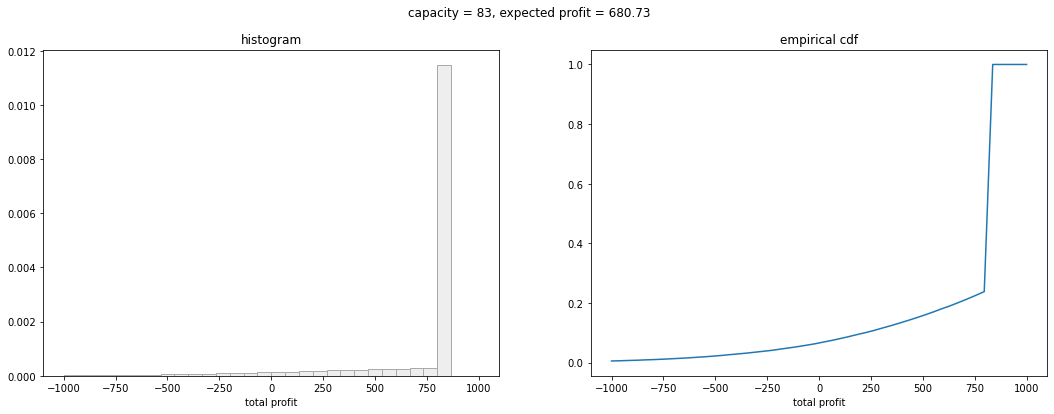

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.suptitle (f'capacity = {capacity}, expected profit = {np.mean(outcomes):.02f}')
axes[0].hist(outcomes, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])    
axes[0].set_xlabel('total profit'); 
axes[0].set_title('histogram'); 

xx = np.linspace(-1000,1000)
ecdf = ECDF(outcomes)
axes[1].plot(xx, ecdf(xx),label=f'capacity={capacity}')
axes[1].set_xlabel('total profit'); 
axes[1].set_title('empirical cdf');

## Motivation: Similar Expected Values, Different Distributions


**Let us consider two different capacity installation decisions:**


In [118]:
capacity_a = 63
capacity_b = 100

Let us compare the outcome distributions of the outcomes of the two capacity decisions:


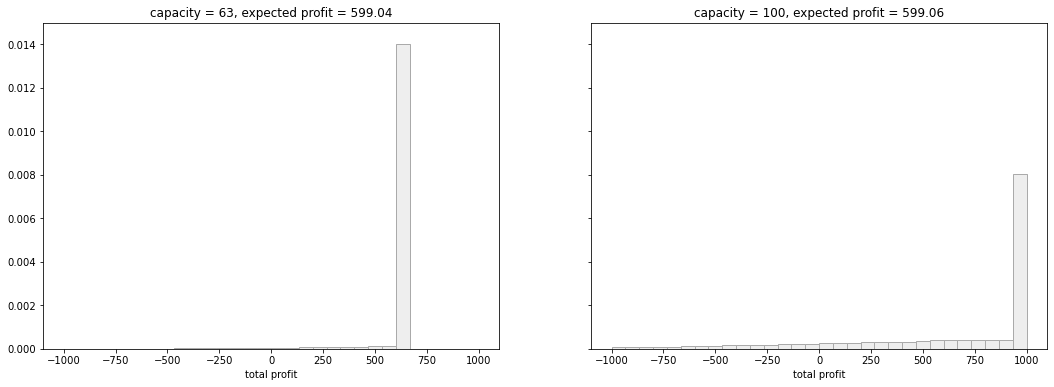

In [127]:
outcomes_a = total_profit(capacity_a,demands)
outcomes_b = total_profit(capacity_b,demands)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
   
axes[0].hist(outcomes_a, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
axes[0].set_ylim ([0, 0.015])
axes[0].set_title(f'capacity = {capacity_a}, expected profit = {np.mean(outcomes_a):.02f}')
axes[0].set_xlabel('total profit');   

axes[1].hist(outcomes_b, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
axes[1].set_ylim ([0, 0.015])
axes[1].set_title(f'capacity = {capacity_b}, expected profit = {np.mean(outcomes_b):.02f}')
axes[1].set_xlabel('total profit');   

## Examples for Information from the Outcome Distribution

- the probability of losing money

In [121]:
print(f"For a capacity of {capacity_a}, the probability of losing money is: { np.mean(outcomes_a < 0) :0.2f}" )
print(f"For a capacity of {capacity_b}, the probability of losing money is: { np.mean(outcomes_b <0) :0.2f}" )

For a capacity of 63, the probability of losing money is: 0.02
For a capacity of 100, the probability of losing money is: 0.16


- the probability of reaching / exceeding a target 

In [123]:
target = 500
print(f"For a capacity of {capacity_a}, the probability of exceeding {target} is: { np.mean(outcomes_a >= target ) :0.2f}" )
print(f"For a capacity of {capacity_b}, the probability of exceeding {target}  is: { np.mean(outcomes_b >= target ) :0.2f}" )

For a capacity of 63, the probability of exceeding 500 is: 0.95
For a capacity of 100, the probability of exceeding 500  is: 0.69


- the value below which the worst 5 % outcomes fall (5%-quantile, Value at Risk)

In [124]:
q = 5

def var_5(outcomes): return np.percentile(outcomes,5)

print(f"For a capacity of {capacity_a}, worst {q} % fall below  { var_5(outcomes_a):0.2f}" )
print(f"For a capacity of {capacity_b}, worst {q} % fall below  { var_5(outcomes_b) :0.2f}" )

For a capacity of 63, worst 5 % fall below  458.48
For a capacity of 100, worst 5 % fall below  -651.52


- the average value of the worst 5 % (Conditional Value at Risk, expected shortfall)

In [125]:
def cvar_5(outcomes): return np.mean(outcomes[outcomes < var_5(outcomes)])

print(f"For a capacity of {capacity_a}, the average of the worst {q} % of the outcomes is { cvar_5(outcomes_a) :0.2f}" )
print(f"For a capacity of {capacity_b}, the average of the worst {q} % of the outcomes is { cvar_5(outcomes_b) :0.2f}" )

For a capacity of 63, the average of the worst 5 % of the outcomes is 43.57
For a capacity of 100, the average of the worst 5 % of the outcomes is -1066.43


## Decision Making as Shaping Distributions

Since, as we learned, different decisions lead to different distributions, we can make the following statement:

**Decision Making under Uncertainty means Shaping (Outcome) Distributions**
- this means we decide between outcome distributions
- the objective function can then be seen as a function taking the outcome distribution as input
- we can choose an objective function that reflects our preferences / risk attitude


## How can we Compare Distributions?

**If decision making means shaping distributions, how can we compare them?**

There is one clear case: **Stochastic Dominance**
- for each outcome, the dominating distribution gives at least as high a probability of obtaining an equal or better outcome than the dominated distribution
- visually, the cdf of the better distribution is always "on the right" of the dominated distribution

**Example:** let us consider yet another production technology for our case study that has a **higher investment cost** and a **lower contribution margin** than the original technology, and take the same capacity decision of 80 for both technologies
- then, the outcome distribution of the original techology dominates the second technology


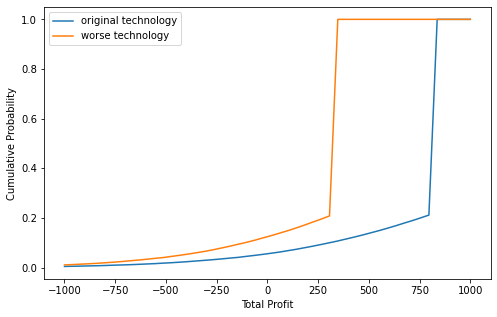

In [130]:
@vectorize
def total_profit_other_technology(capacity,demands):
    return -31*capacity + 35*min(capacity, demands)
plt.figure(figsize=(8,5))
ecdf = ECDF(total_profit(80,demands))
plt.plot(xx, ecdf(xx), label="original technology")

ecdf = ECDF(total_profit_other_technology(80,demands))
plt.plot(xx, ecdf(xx), label="worse technology")
plt.legend()
plt.xlabel('Total Profit')
plt.ylabel('Cumulative Probability');         

## How can we Compare Distributions?

**In general, stochastic dominance is an exception**: Typically, alternatives with a lower risk of bad outcomes also exhibit samller chances of very good outcomes



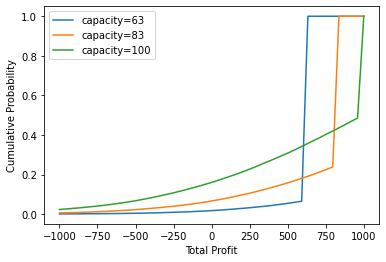

In [132]:
from statsmodels.distributions.empirical_distribution import ECDF

values_to_plot = [63, 83, 100]

xx = np.linspace(-1000,1000)

#fig, axes = plt.subplots(1, len(values_to_plot), figsize=(6*len(values_to_plot), 4), constrained_layout=True)

for index in range(len(values_to_plot)):
    ecdf = ECDF(total_profit(values_to_plot[index],demands))
    plt.plot(xx, ecdf(xx),label=f'capacity={values_to_plot[index]}')
    #axes[index].set_title(f'capacity = {values_to_plot[index]}, expected profit = {expected_profit(values_to_plot[index]):.02f}')
    
plt.legend()
plt.xlabel('Total Profit')
plt.ylabel('Cumulative Probability');

#plt.savefig("cumulative_result_distributions.pdf",bbox_inches="tight")


To decide between outcome distributions we can use (for example):
- distribution statistics (e.g. mean, mode, ...)
- risk measures
- utility functions



# Excercise: The Second Production Technology




## An additional production technology

The company from the capacity planning case study thinks of installing production capacity using an different production technology (B).

Technology B has a lower installation costs (\\$ 20 per unit), but also a lower contribution margin per sold unit (\\$ 28) compared to the original technology A.

Below, please find our implementation from before:

In [134]:

@vectorize
def total_profit_b(capacity,demand):
    return -20*capacity + 28* min(capacity, demand)

demands = demand_dist.rvs(n_samples)
# decision
capacity = 84

#we can now call the function with an array parameter returning an array of profits
profit = total_profit_b(capacity,demands)

expected_profit = np.mean(profit)

print(f'The estimated expected profit is: {expected_profit:.2f}')

The estimated expected profit is: 561.15


**Task:**

Compare the outcome distributions from the optimal decisions for both production technologies:
- compute the best outcome distribution for each of the technologies (either using enumeration or scipy optimize)
- which outcome distribution has a higher probability of losing money?
- does one of the distributions stochastically dominate the other?


In [135]:
def neg_expected_profit_b(capacity, demands):
    return -1*np.mean(total_profit_b(capacity,demands))

result_b = minimize(neg_expected_profit_b, 100, args=(demands))

total_profits_a = total_profit(result.x[0],demands)
total_profits_b= total_profit_b(result_b.x[0],demands)

## Exercise, Continued 
Now consider a combination of both technologies, that is, you may install both technology A and B. 

Since B has a lower profit contribution, you assume that if  both technologies are installed, first A is used to produce up to the installed capacity. If there is demand left, that demand is satisfied by technology B until the installed capacity of B is exhausted.

What is the best combination of technologies A and B in terms of expected total profit? Is B used at all? 

See a solution below


In [137]:
capacityA = 80
capacityB = 20

@vectorize
def total_profit_both(capacityA, capacityB, demand):
    capacity_cost =  -30*capacityA -20 *capacityB 
    soldA =  min(capacityA, demand)  
    soldB =  min(capacityB, demand-soldA)
    return capacity_cost + 40*soldA + 28*soldB

best_profit = 0
best_A = 0
best_B = 0
for capA in np.arange(160):
    for capB in np.arange(160):
        profit = np.mean(total_profit_both(capA,capB,demands))
        if profit > best_profit:            
            best_combined_distribution = total_profit_both(capA,capB,demands)
            best_profit = profit
            best_A = capA
            best_B = capB            
print(f'Best A: {best_A}, best b {best_B}, estimated expected profit is: {best_profit:.2f}')

Best A: 76, best b 10, estimated expected profit is: 686.76


**Task:**

Compare the outcome distributions from the optimal decisions for only using the original techology and for the combination of  both production technologies computed using the code above!
- modify the code from the cell above to also store the best profit distribution
- compute the best outcome distribution for each of the technologies (either using enumeration or scipy optimize)
- which outcome distribution has a higher probability of losing money?
- does one of the distributions stochastically dominate the other?


# Risk-Oriented Decision Making under Uncertainty

## Risk-Oriented Decision Making under Uncertainty

In the last part, we learned that 

- **decision making under uncertainty means shaping distributions**

In this part, we deal with approaches for influencing the shapes of distribitions, mainly in a way that follows risk preferences:
- penalizing shortfalls below targets
- utility theory: utility functions as objective functions
- mean-risk objectives based on risk measures

# Shaping Distributions by Penalizing Shortfalls

## Shaping Distributions by Penalizing Shortfalls


**Idea: Set target values and penalize the violations / shortfall**
- as soon the target is violated, the shortfall is penalized with a
  weight $\lambda$
- can be used to reduce risk of obtaining bad or negative outcomes

**Example for our case study:**
- say we'd like to penalize total profits smaller than \\$500k
- we can change our objective function $f$ to $f'$ as follows:

$$f'(x,d) = f(x,d) - \lambda \max(500 - f(x,d), 0)$$

For deciding under demand uncertainty, we then then maximize the **expected value  $E(f'(x,D))$** instead of maximizing $E(f(x,D))$

In Python:

In [138]:
target_profit = 500
shortfall_penalty = 2

@vectorize
def total_profit_and_shortfall_penalty(capacity,demand, target_profit, shortfall_penalty):
    profit = -30*capacity + 40* min(capacity, demand)
    return profit - shortfall_penalty * max(target_profit - profit, 0)

    

## Optimizing the Shortfall-based Penalty

**Let us optimize for the shortfall-based penalty**

Recall that the optimal decision in the risk-neutral case is $\approx$ 83.

Using $f'$ as optimization criterion, a target value of 500  and a penalty of 2, we get the following result:



In [142]:
# not that we negate the function here since we'd like to use minimize

def neg_expected_total_profit_and_shortfall_penalty(capacity, demands, target_profit, shortfall_penalty):
    return -np.mean(total_profit_and_shortfall_penalty(capacity, demands, target_profit, shortfall_penalty))

shortfall_penalty = 2
result = minimize(neg_expected_total_profit_and_shortfall_penalty,100,args=(demands, 500, shortfall_penalty))

print(f'Given a target value of {target_profit} and a shortfall penalty lambda= {shortfall_penalty}, the optimal capacity decision is {result.x[0]:.2f}')

Given a target value of 500 and a shortfall penalty lambda= 2, the optimal capacity decision is 70.90


A penalty of 4 is even more risk averse:

In [143]:
shortfall_penalty = 4
result = minimize(neg_expected_total_profit_and_shortfall_penalty,100,args=(demands, 500, shortfall_penalty))

print(f'Given a target value of {target_profit} and a shortfall penalty lambda= {shortfall_penalty}, the optimal capacity decision is {result.x[0]:.2f}')

Given a target value of 500 and a shortfall penalty lambda= 4, the optimal capacity decision is 64.15


# Utility Functions / Utility Theory

## Utility Functions

In **utility theory**, the results of decisions are valued
by a utility function $u$.
- for a given decision $x$ and deterministic parameters $d$, we can then use $u(f(x,d))$ for evaluating a decision
- for decisions under uncertainty, we maximize the **expected utility** $E(u(f(x,D)))$
- an important class of utility functions are **exponential utility functions**

$$u(x)=1-e^{-f(x)/R}$$

where
- $f(x)$ is the (monetary) profit from taking decision $x$ and
- $D$ is the (vector) of uncertain parameters
- $R$ is the so-called **risk tolerance**
- $R$ is the greatest value for which you would take the gamble
  - win $R$ with probability 0.5
  - lose $R/2$ with probability 0.5

In general, the **exponential** utility function assumes that the subjective value of each additional unit of profit decreases with increasing profit


## In our Example:

Let us illustrate an exponential utility function for our case study:

- we define a function `exponential_utility` that, for a given `risk_tolerance` $R$, returns
  - the utility of a single `profit` value or
  - an array of utilities if `profit` is an array of profits, e.g. from a Monte Carlo simulation

In [144]:
from math import exp
@vectorize
def exponential_utility (profit, risk_tolerance):
    return 1-exp(-profit/risk_tolerance)

Let us now plot the the utilies of different total profits for different risk tolerances:

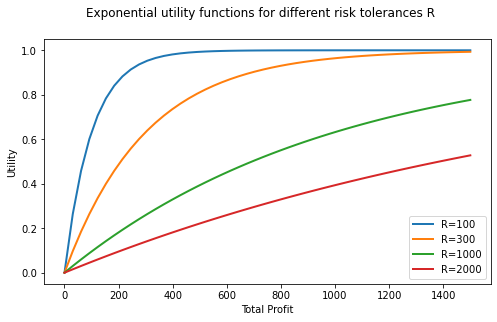

In [145]:
risk_tolerances = [100, 300, 1000, 2000]
xx = np.linspace(0, 1500)

plt.figure(figsize=(8,4.5))
for risk_tolerance in risk_tolerances:
    yy = exponential_utility (xx, risk_tolerance)
    plt.plot(xx, yy, linewidth=2,label = f'R={risk_tolerance}')

plt.suptitle('Exponential utility functions for different risk tolerances R')
plt.legend()
plt.xlabel('Total Profit')
plt.ylabel('Utility');

## Optimizing Expected Utility

If we use the utility function for decision-making, we maximize the expected utility, that is:

$$\max_{x \in X} E(u(f(x,D)))$$

In our example, this means that we choose the capacity that give us the outcome / profit distribution with the best expected profit.
- to achieve this, we define the following objective function that takes a capacity decision, an array of demand samples and a risk tolerance $R$, and returns a sample approximation of the expected utility:

In [146]:
def expected_exponential_utility_fixed_risk_tolerance (capacity, demands, risk_tolerance):
    return np.mean(exponential_utility(total_profit(capacity,demands), risk_tolerance))

For use with scipy's `minimize`, we can write the negated objective function as follows:

In [147]:
def neg_expected_exponential_utility_fixed_risk_tolerance (capacity, demands, risk_tolerance):
    return -expected_exponential_utility_fixed_risk_tolerance (capacity, demands, risk_tolerance)

## Results for different risk tolerances

Now, we can play with different risk tolerances:
- $R$ = 100

In [148]:
risk_tolerance = 100
result = minimize(neg_expected_exponential_utility_fixed_risk_tolerance, 100, args=(demands, risk_tolerance))
print(f'Given a risk tolerance of {risk_tolerance}, the optimal capacity decision is {result.x[0]:.2f}')

Given a risk tolerance of 100, the optimal capacity decision is 12.58


- $R$ = 500

In [149]:
risk_tolerance = 500
result = minimize(neg_expected_exponential_utility_fixed_risk_tolerance, 100, args=(demands, risk_tolerance))
print(f'Given a risk tolerance of {risk_tolerance}, the optimal capacity decision is {result.x[0]:.2f}')

Given a risk tolerance of 500, the optimal capacity decision is 64.38


- $R$ = 1000

In [151]:
risk_tolerance = 1000
result = minimize(neg_expected_exponential_utility_fixed_risk_tolerance, 100, args=(demands, risk_tolerance))
print(f'Given a risk tolerance of {risk_tolerance}, the optimal capacity decision is {result.x[0]:.2f}')

Given a risk tolerance of 1000, the optimal capacity decision is 74.04


# Deciding / Optimizing with Risk Measures

## The Value at Risk

**The q%-Value at Risk (VaR$_q$) of an outcome distribution G**
- is the outcome value separating the q% of the worst cases from the 1-q% of the best cases
- corresponds to the *q-percentile* or the *q/100 quantile* of $G$
- VaR is a risk measure often used in the financial industry and in risk reporting

**Given a set of |S| samples from $G$, VaR$_q$(G) can be obtained by**
- sorting the sample values $g_s$ in an increasing order and
- selecting the sample with first index that is greater than $q/100|S|$
- `numpy` offers functions for computing quantiles / percentiles:

In [48]:
capacity = 83
total_profit_samples = total_profit(capacity,demands)
q = 5
var_q = np.percentile(total_profit_samples, q)

print(f"For a capacity decision of {capacity} , the {q} percent value at risk is {var_q:0.2f}")


For a capacity decision of 83 , the 5 percent value at risk is -129.79


## Conditional Value at Risk

A **disadvantage** of VaR is that it does not consider **how bad** the outcomes below the VaR are


This is overcome by the **Conditional Value at Risk** (CVar). The **q%-CVaR (CVaR$_q$)** corresponds to
- the average / expected value of the distribution of values below VaR
- it is also called **Expected Shortfall**

**Given a set of |S| samples from $G$, CVaR$_q$(G) can be approximated by**
- taking the average of all samples $g_s$ falling below  VaR


In [49]:
total_profit_below_var = total_profit_samples[total_profit_samples <= var_q] 
cvar_q = total_profit_below_var.mean()
print(f"For a capacity decision of {capacity} , the {q} percent conditional value at risk is {cvar_q:0.2f}")

For a capacity decision of 83 , the 5 percent conditional value at risk is -539.30


## Value at Risk and Conditional Value at Risk

Let us visualize these Value at Risk and Condidtional Value at Risk along with the histogram of the distribution:


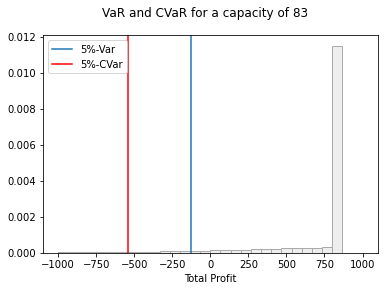

In [50]:

# plot value at risk according to different


count, bins, ignored = plt.hist(total_profit_samples, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])

plt.suptitle(f'VaR and CVaR for a capacity of {capacity}')
plt.axvline(x=var_q, label = f'{q}%-Var')
plt.axvline(x=cvar_q, label = f'{q}%-CVar',color='r')
plt.xlabel('Total Profit')
plt.legend()
plt.show()

## Comparing CVaR and VaR for different capacities

Now, we compare VaR and CVaR for two capacity decisions that have almost the same expected total profit: 63 and 100

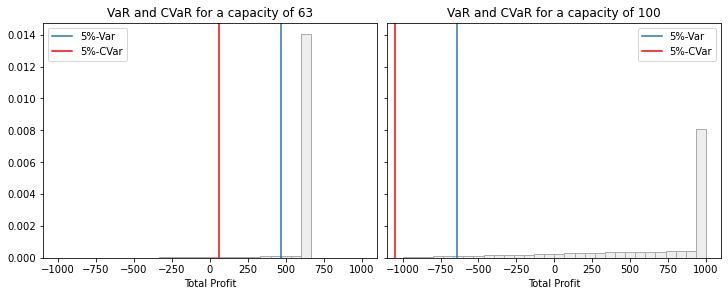

In [51]:
values_to_plot = [63, 100]
qq = 5

fig, axes = plt.subplots(1, len(values_to_plot), figsize=(5*len(values_to_plot), 4), constrained_layout=True, sharey=True)

for index in range(len(values_to_plot)):
    
    capacity =values_to_plot[index]
    total_profit_samples = total_profit(capacity,demands)

    var_q = np.percentile(total_profit_samples, q)

    total_pr_below_var = total_profit_samples[total_profit_samples <= var_q] 

    
    cvar_q = total_pr_below_var.mean()

    #print(cvar_q)
    
    count, bins, ignored = axes[index].hist(total_profit_samples, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
    axes[index].set_title(f'VaR and CVaR for a capacity of {capacity}')
    axes[index].axvline(x=var_q, label = f'{q}%-Var')
    axes[index].axvline(x=cvar_q, label = f'{q}%-CVar',color='r')
    axes[index].set_xlabel('Total Profit')
    axes[index].legend()

#plt.savefig("var_and_cvar_comparison.pdf",bbox_inches="tight")
plt.show()


## Mean-Risk Objective

For decision making and optimization under uncertainty, we can use risk measures in so-called **mean-risk** objectives:

- similar to the shortfall penalty, we augment the objective by adding the risk measure (call it $h(x,D)$ here) with a weight $\lambda$
- the mean-risk objective to be maximized then becomes:

$$f^{mean-risk}(x,D) = E(f(x,D)) + \lambda h(x,D)$$

Here, we consider the tow cases VaR and CVaR:

$$f^{mean-VaR}(x,D) = E(f(x,D))+ \lambda \mathrm{VaR}(x,D)$$

$$f^{mean-CVaR}(x,D) = E(f(x,D))+ \lambda \mathrm{CVaR}(x,D)$$

## Exercise: Optimizing Mean-Risk Objectives

- implement the mean-risk objectives for VaR and CVaR in Python
- solve the capacity planning problem for these two objectives and play with different values of $\lambda$

- **hint:** use a negated objective function and scipy's `minimize` for the optimization

## Conclusions

In this meeting, we dealt with:
- the **fundamental structure of decision making problems under uncertainty**
- how to take decision maximizing expected outcome
- how to use **unconstrained optimization** for selecting decisions
- the **value of proper decision-making under uncertainty**
- the **value of information** and its relation to decision-making under uncertainty
- the idea that **decision making means shaping distributions** 
- different ways to **incorporate risk aversion in decision making under uncertainty** 

**In the next meeting,  we will:**
- start discussing how to deal with **uncertainty in (mixed-integer) linear programming**
